# Custom Variational Steppers with `clvlib.numpy`

This notebook demonstrates how to extend `clvlib.numpy` with custom steppers engineered for the coupled state/variational equations. You will:
- review the stepper interface,
- implement a classical RK3/8 method that advances both the state and tangent dynamics,
- register the stepper so the high-level APIs can use it,
- compare its results with the built-in RK4,
- pass a custom callable directly without touching the global registry.
        


## Prerequisites

Run the imports below before executing the rest of the notebook.
        


In [12]:
import numpy as np
import matplotlib.pyplot as plt

from clvlib.numpy import (
    lyap_analysis_from_ic,
    lyap_exp_from_ic,
    register_stepper,
    resolve_stepper,
)
        


## 1. Understand the stepper contract

A variational stepper advances both the state `x` and the variational basis `V` over one fixed time step. Any callable with the signature below is compatible:

```
def variational_step(f, Df, t, x, V, dt, *args) -> tuple[np.ndarray, np.ndarray]:
    ...
```

`clvlib.numpy.steppers.resolve_stepper` returns the built-ins (`"euler"`, `"rk2"`, `"rk4"`, `"discrete"`) for reference or reuse.
        


In [2]:
rk4_step = resolve_stepper("rk4")
print(rk4_step.__doc__)
        


Fourth-order Runge–Kutta for state and variational system.


## 2. Define the Lorenz '63 system

We will compare steppers on the Lorenz '63 flow and its analytical Jacobian.
        


In [5]:
SIGMA = 10.0
RHO = 28.0
BETA = 8.0 / 3.0

def lorenz(t: float, x: np.ndarray) -> np.ndarray:
    return np.array([
        SIGMA * (x[1] - x[0]),
        x[0] * (RHO - x[2]) - x[1],
        x[0] * x[1] - BETA * x[2],
    ], dtype=float)

def jacobian(t: float, x: np.ndarray) -> np.ndarray:
    return np.array([
        [-SIGMA, SIGMA, 0.0],
        [RHO - x[2], -1.0, -x[0]],
        [x[1], x[0], -BETA],
    ], dtype=float)
        


## 3. Implement an RK3/8 variational stepper

The classical 3/8 rule matches the order of RK4 but uses different stage weights. We mirror the state updates for the variational basis so that the tangent dynamics stay consistent.
        


In [6]:
def rk38_step(f, Df, t, x, V, dt, *args):
    k1 = dt * f(t, x, *args)
    K1 = dt * (Df(t, x, *args) @ V)

    x2 = x + (1.0 / 3.0) * k1
    V2 = V + (1.0 / 3.0) * K1
    k2 = dt * f(t + dt / 3.0, x2, *args)
    K2 = dt * (Df(t + dt / 3.0, x2, *args) @ V2)

    x3 = x + (-1.0 / 3.0) * k1 + k2
    V3 = V + (-1.0 / 3.0) * K1 + K2
    k3 = dt * f(t + 2.0 * dt / 3.0, x3, *args)
    K3 = dt * (Df(t + 2.0 * dt / 3.0, x3, *args) @ V3)

    x4 = x + k1 - k2 + k3
    V4 = V + K1 - K2 + K3
    k4 = dt * f(t + dt, x4, *args)
    K4 = dt * (Df(t + dt, x4, *args) @ V4)

    x_next = x + (k1 + 3.0 * k2 + 3.0 * k3 + k4) / 8.0
    V_next = V + (K1 + 3.0 * K2 + 3.0 * K3 + K4) / 8.0
    return x_next, V_next
        


## 4. Register the stepper and compare with RK4

We integrate the Lorenz system for 40 time units and contrast the asymptotic Lyapunov exponents obtained with RK3/8 and RK4.
        


In [7]:
register_stepper("rk38", rk38_step)

# Shared integration grid
n_steps = 4000
T = 40.0
times = np.linspace(0.0, T, n_steps + 1)
x0 = np.array([8.0, 0.0, 30.0], dtype=float)

LE_rk38, LE_hist_rk38, BLV_hist_rk38, CLV_hist_rk38, trajectory_rk38 = (
    lyap_analysis_from_ic(
        lorenz,
        jacobian,
        x0,
        times,
        stepper="rk38",
        qr_method="householder",
        ginelli_method="ginelli",
    )
)

LE_rk4, _, _, _, trajectory_rk4 = lyap_analysis_from_ic(
    lorenz,
    jacobian,
    x0,
    times,
    stepper="rk4",
    qr_method="householder",
    ginelli_method="ginelli",
)

print("Asymptotic Lyapunov exponents (RK3/8):", LE_rk38)
print("Asymptotic Lyapunov exponents (RK4)  :", LE_rk4)
print("Absolute difference:", np.abs(LE_rk38 - LE_rk4))
        


Asymptotic Lyapunov exponents (RK3/8): [  0.89740499  -0.04177995 -14.52219313]
Asymptotic Lyapunov exponents (RK4)  : [  0.87318906  -0.02318648 -14.51656772]
Absolute difference: [0.02421593 0.01859347 0.00562541]


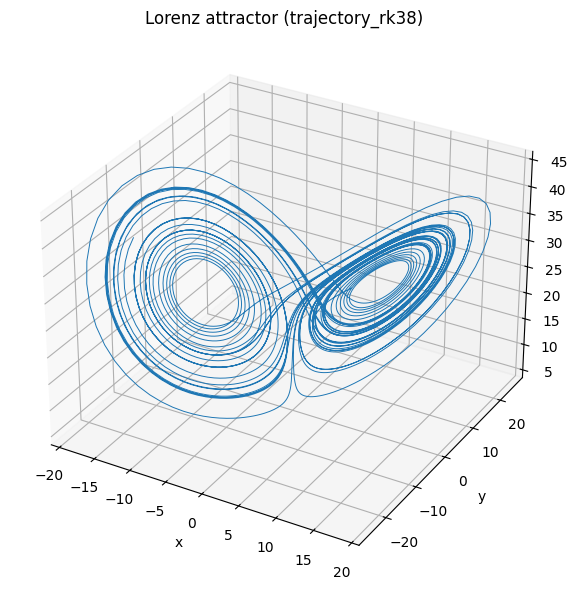

In [ ]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = trajectory_rk38[:, 0]
y = trajectory_rk38[:, 1]
z = trajectory_rk38[:, 2]

# color by time for a sense of temporal evolution
ax.plot(x, y, z, color='tab:blue', linewidth=0.7)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz attractor (trajectory_rk38)')

plt.tight_layout()
plt.show()

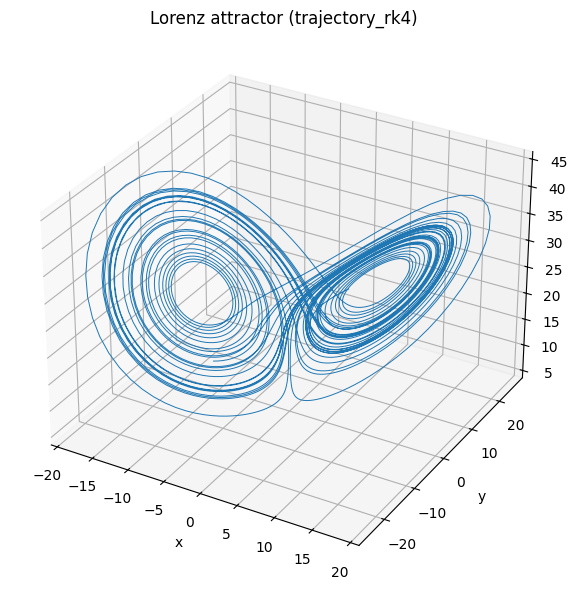

In [15]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = trajectory_rk4[:, 0]
y = trajectory_rk4[:, 1]
z = trajectory_rk4[:, 2]

# color by time for a sense of temporal evolution
ax.plot(x, y, z, color='tab:blue', linewidth=0.7)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz attractor (trajectory_rk4)')

plt.tight_layout()
plt.show()

## 5. Use an inline custom stepper

You can also pass a custom callable directly without registering it. Below we apply a simple damped Euler step, which intentionally trades accuracy for speed.
        


In [19]:
def heun_step(f, Df, t, x, V, dt, *args):
    k1 = dt * f(t, x, *args)
    K1 = dt * (Df(t, x, *args) @ V)

    x_pred = x + k1
    V_pred = V + K1

    k2 = dt * f(t + dt, x_pred, *args)
    K2 = dt * (Df(t + dt, x_pred, *args) @ V_pred)

    x_next = x + 0.5 * (k1 + k2)
    V_next = V + 0.5 * (K1 + K2)
    return x_next, V_next

LE_heun, LE_hist_heun, trajectory_heun = lyap_exp_from_ic(
    lorenz,
    jacobian,
    x0,
    times,
    stepper=heun_step,
    return_blv=False,
    qr_method="householder",
)

print("Asymptotic Lyapunov exponents (damped Euler):", LE_heun)
        


Asymptotic Lyapunov exponents (damped Euler): [  0.92817709  -0.05716357 -14.46204689]


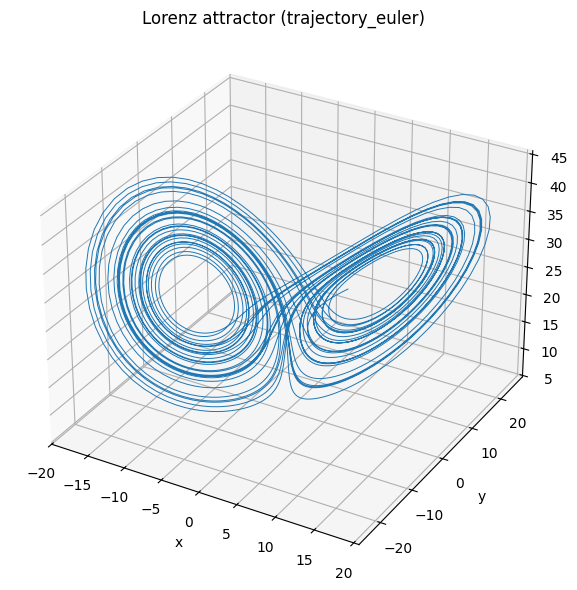

In [20]:
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')

x = trajectory_heun[:, 0]
y = trajectory_heun[:, 1]
z = trajectory_heun[:, 2]

# color by time for a sense of temporal evolution
ax.plot(x, y, z, color='tab:blue', linewidth=0.7)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Lorenz attractor (trajectory_euler)')

plt.tight_layout()
plt.show()